# Setup/Imports

In [1]:
%%capture
from src.drops import Drops

drop_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=2.5
)

The code for the [`Drops`](../src/drops.py) class subclasses [`Results`](../utils/results.py) and is shown below:
```python
class Results:
    ...
    @property
    def teams(self) -> list[int]:
        ...
    @property
    def teams_data(self) -> list[dict[str, str | int]]:
        ...
    @property
    def events(self) -> list[str]:
        ...
    @property
    def trial_events(self) -> list[str]:
        ...
    @property
    def score_sum(self) -> dict[int, int]:
        ...
    @property
    def full_scores(self) -> dict[int, list[int]]:
        ...
    @property
    def averages(self) -> dict[int, float]:
        ...

```
```python
class Drops(Results):
    ...
    def iqr(self, alpha: float = ...) -> None:
        """Calculates the IQR method for determining "bombed" events"""
        ...
    def mean(self, alpha: float = ...) -> None:
        """Calculates the mean method for determining "bombed" events"""
        ...
    def std_deviation(self, alpha: float = ...) -> None:
        """Calculates the standard deviation method for determining "bombed" events"""
        ...
    def drop(self) -> None:
        """Drops the "bombed" events from the scores"""
        ...
    def visualize(self) -> None:
        """Visualizes the data"""
        ...
    
```

## Average Score Per School

In [2]:
import utils

print(
    "Average score per school: ",
    utils.pretty_print(
        drop_model.teams,
        dict(sorted(drop_model.averages.items(), key=lambda item: item[1])),
    ),
)

Average score per school:  {'Adlai E. Stevenson High School ': 9.043478260869565, 'Solon High School ': 9.91304347826087, 'Mason High School ': 10.130434782608695, 'Troy High School ': 12.130434782608695, 'Harriton High School ': 12.73913043478261, 'Acton-Boxborough Regional High School ': 12.956521739130435, 'Castro Valley High School ': 13.956521739130435, 'Seven Lakes High School ': 14.173913043478262, 'New Trier High School ': 14.478260869565217, 'William G. Enloe High School ': 15.956521739130435, 'Marquette University High School ': 16.08695652173913, 'Syosset High School ': 16.565217391304348, 'Grand Haven High School ': 17.608695652173914, 'Lower Merion High School ': 18.130434782608695, 'West Windsor-Plainsboro High School North ': 18.391304347826086, 'William P. Clements High School ': 20.08695652173913, 'North Carolina School of Science and Mathematics ': 20.434782608695652, 'Carmel High School ': 20.434782608695652, 'Ward Melville High School ': 20.73913043478261, 'F.W. Buc

# Distinguishing "Bombed" Events
### Using the following methods to determine "bombed" events:
##### These values become the upper fence for the data
- [$\alpha \times \overline{X} $](../src/drops.py#L38)
- [$\alpha \times (Q_3 - Q_1) + Q_3$ &nbsp; (IQR)](../src/drops.py#L30)
- [$\alpha \times \sigma + \overline{X} $&nbsp;&nbsp;&nbsp; (Standard Deviation)](../src/drops.py#L44)

where $\alpha$ is a multiplicative constant


### Mean Method (alpha = 2)

In [3]:
%%capture
# redefine our model to use this method
mean_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="mean", alpha=2
)
mean_model.drop()

### IQR Method (alpha = 1.5, standard outlier formula)

In [4]:
%%capture
# redefine our model to use this method
iqr_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="iqr", alpha=1.5
)
iqr_model.drop()

### Standard Deviation Method (alpha = 1.5)

In [5]:
%%capture
# redefine our model to use this method
std_dev_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=1.5
)
std_dev_model.drop()

## Consistent Flaws
All of these methods are too sensitive to "top" teams while do not account nearly as well for lower ranked teams. A possible solution would be a scalar multiplier based on the team's rank. This would have a greater account for bombs even when the mean/median place on a team is lower. 

## Calculating Bombed Events
Using the standard deviation method with $\alpha = 1.5$ to determine "bombed" events as a demonstration


In [6]:
%%capture
std_dev_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=1.5
)

std_dev_model.drop()

In [7]:
utils.pretty_print(
    std_dev_model.teams,
    dict(sorted(std_dev_model.bombed_events.items(), key=lambda item: item[1])),
)

{'Ravenwood High School ': [],
 'Blue Valley North High School ': [],
 'Charter School of Wilmington ': [],
 'James Clemens High School ': [],
 'Bismarck High School ': [],
 'Hamilton High School ': [],
 'Albuquerque Academy ': [],
 'University High School ': [],
 'Barrington High School ': [],
 'Northwest Rankin High School ': [],
 'Lebanon High School ': [],
 'Clinton High School ': [],
 "St. Mary's Academy ": [],
 'West High School ': [],
 'Waynflete Upper School ': [],
 'Baton Rouge Magnet High School ': [],
 'Kelly Walsh High School ': [],
 'Saint Johnsbury Academy ': [],
 'BASIS Independent Washington, D.C. ': [],
 'Iolani School ': ['Anatomy and Physiology', 'Environmental Chemistry'],
 'Pioneer High School ': ['Anatomy and Physiology', 'Write It Do It'],
 'William G. Enloe High School ': ['Astronomy', 'Scrambler'],
 'Seven Lakes High School ': ['Bridge'],
 'Syosset High School ': ['Bridge', 'Flight', 'Remote Sensing'],
 'Carmel High School ': ['Bridge', 'Green Generation'],
 'E

## Recalculating scores/ranking with auto drop "bombed" events
### Dropping $\lfloor{\frac{\sum_n^k{b_n}}{k-n}}\rfloor$ (avg) "bombed" events from each team's scores

In [8]:
utils.pretty_print(
    std_dev_model.teams,
    dict(sorted(std_dev_model.dropped_scores.items(), key=lambda item: item[1])),
)

{'Adlai E. Stevenson High School ': 184,
 'Solon High School ': 192,
 'Mason High School ': 193,
 'Acton-Boxborough Regional High School ': 248,
 'Troy High School ': 252,
 'Harriton High School ': 262,
 'Castro Valley High School ': 270,
 'Seven Lakes High School ': 281,
 'New Trier High School ': 283,
 'Syosset High School ': 328,
 'William G. Enloe High School ': 330,
 'Marquette University High School ': 337,
 'Grand Haven High School ': 360,
 'Lower Merion High School ': 376,
 'West Windsor-Plainsboro High School North ': 383,
 'William P. Clements High School ': 414,
 'North Carolina School of Science and Mathematics ': 416,
 'Carmel High School ': 419,
 'Ward Melville High School ': 438,
 'F.W. Buchholz High School ': 449,
 'duPont Manual High School ': 454,
 'Pioneer High School ': 487,
 'Ladue Horton Watkins High School ': 490,
 'Centennial High School ': 490,
 'Brookwood High School ': 514,
 'Thomas Jefferson High School for Science and Technology ': 518,
 'Iolani School ': 5

# Visualization of Data
We can see overall placement changes between teams as well as an overall trend as to how dropping affects the shape of the relationship/curve between teams and their scores.

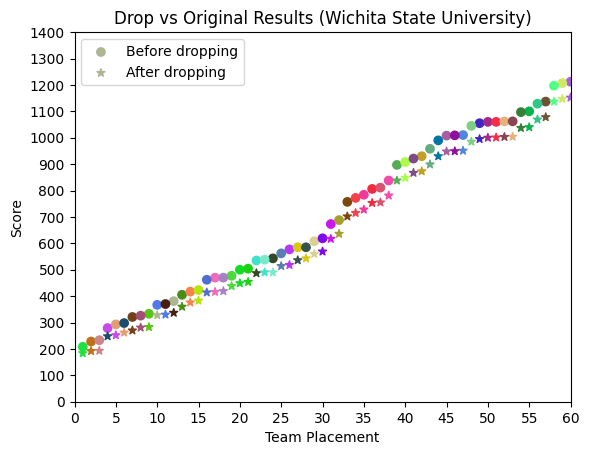

In [9]:
std_dev_model.visualize()